# 签到项目

我们用基本知识里的方法开发一个签到系统，当摄像头探测到用户的脸时自动记录下来。这里会把对应人第一次出现的时间作为他的名字。

# 引入图片：

像前面引入一样，使用face_recognition.load_image_file()函数引入我们需要的图片。当有很多图片时，引入他们会导致混乱。我们会写一个脚本从指定的文件夹中一次引入所有的图片。这里需要引入os库来操作文件夹。把所有的图片存到一个list中，把对应的名字存到另外一个list中。


使用对应的方法之前需要先引入一下：

In [1]:
import face_recognition
import cv2
import numpy as np
import os

定义常量及变量

In [2]:
path = 'ImagesAttendance'
images = []     # 存储所有图片的list
className = []    # 存储对应的类名
myList = os.listdir(path)

输出看看发现多少个文件，其实在python脚本里是没有ipynb_checkpoints文件的，在这里需要处理掉

In [3]:
print("Total Classes Detected:",len(myList))

Total Classes Detected: 6


In [4]:
for x,cl in enumerate(myList):
        curImg = cv2.imread(f'{path}/{cl}')
        images.append(curImg)
        #print(os.path.splitext(cl)[0])
        className.append(os.path.splitext(cl)[0])

看看文件名都有哪些：

In [5]:
print(className)

['Bill-Gates', 'Elon-Musk', 'Elon-Test', '.ipynb_checkpoints', 'Jack-Ma', 'Shi-Hailong']


比对结果可以发现有6个元素,而文件夹中只有5个元素,多了一个'.ipynb_checkpoints'

而这个元素不是图片,所以我们可以查找并删除该元素

found 用来标识是否发现了无用的元素

deleted 用来标识是否已经删除过,避免多次删除从而把有用的删除了

In [6]:
deleted_idx = 'no'
found = False
deleted = False

for item in className:
    if item == '.ipynb_checkpoints':
        deleted_idx = className.index(item)
        found = True
if found == True and deleted == False:
    del(className[deleted_idx])
    del(images[deleted_idx])
    deleted = True

打印一下看看，是不是把表示图片的假文件从list中删除了

In [7]:
print(className)

['Bill-Gates', 'Elon-Musk', 'Elon-Test', 'Jack-Ma', 'Shi-Hailong']


可以多执行几遍上面的两段代码，看是否会把其他的图片删除呢，体味一下found和deleted的使用，能不能分清楚ｆｏｒ语句和ｉｆ语句分别执行了几遍呢

# 计算编码

现在有一些图片在list中，可以把它们生成已知人名的编码。这里通过定义一个函数来实现该功能。像前面一样，先转换成RGB再转成对应的编码，最后添加到定义的list中。


In [8]:
def findEncodings(images):
    encodeList = []
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        encode = face_recognition.face_encodings(img)[0]
        encodeList.append(encode)
    return encodeList

现在可以容易的调用这个函数，把图片list作为输入参数。

In [9]:
encodeListKnown = findEncodings(images)
print('Encodings Complete')

Encodings Complete



# 相机图片

保存一张相机的图片试试

In [10]:
import cv2
from matplotlib import pyplot as plt

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-pse1o4hc because the default path (/home/jetbot/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


函数gstreamer_pipeline是调用CSI相机需要的参数，其中1080和720为图像的尺寸，不要改，改了可能无法识别人脸

In [11]:
def gstreamer_pipeline(capture_width=1080, capture_height=720, display_width=1080, display_height=720, framerate=30, flip_method=0,):
    return (
        "nvarguscamerasrc ! "
        "video/x-raw(memory:NVMM), "
        "width=(int)%d, height=(int)%d, "
        "format=(string)NV12, framerate=(fraction)%d/1 ! "
        "nvvidconv flip-method=%d ! "
        "video/x-raw, width=(int)%d, height=(int)%d, format=(string)BGRx ! "
        "videoconvert ! "
        "video/x-raw, format=(string)BGR ! appsink"
        % (
            capture_width,
            capture_height,
            framerate,
            flip_method,
            display_width,
            display_height,
        )
    )

初始化相机对象

In [16]:
video = cv2.VideoCapture(gstreamer_pipeline(flip_method=0), cv2.CAP_GSTREAMER)

获取一张图片,作为打卡签到的图片

In [17]:
success,imgS = video.read()
#imgS = cv2.resize(imgS, (0, 0), fx=0.25, fy=0.25)
imgS = cv2.cvtColor(imgS, cv2.COLOR_BGR2RGB)

把照片显示出来

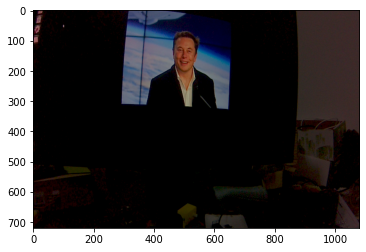

In [18]:
plt.imshow(imgS)
plt.show()

In [19]:
video.release()#释放相机对象

# 网络相机编码
得到网络相机的图片后，接着找到图片上所有的脸，face_locations函数就是做这件事的。接着用face_encodings。

In [20]:
facesCurFrame = face_recognition.face_locations(imgS)
encodesCurFrame = face_recognition.face_encodings(imgS, facesCurFrame)

In [21]:
#print(facesCurFrame)
#print(encodesCurFrame)

# 匹配运算
现在可以通过把当前图片的编码和已知图片的编码进行比较来发现是谁。这里也会计算相似性，以防在一次比较中发现多个人，这样可以选择最相似的那个人。

In [22]:
for encodeFace,faceLoc in zip(encodesCurFrame,facesCurFrame):
    matches = face_recognition.compare_faces(encodeListKnown, encodeFace)
    faceDis = face_recognition.face_distance(encodeListKnown, encodeFace)

一旦得到人脸差距的list后，就可以发现差距最小的那个，这个就是最佳匹配。

In [23]:
matchIndex = np.argmin(faceDis)
print(matchIndex)

1


现在就可以根据索引值确定显示的图片对应的人名。

In [24]:
if matches[matchIndex]:
    name = className[matchIndex].upper()
    y1,x2,y2,x1=faceLoc
    y1, x2, y2, x1 = y1*4,x2*4,y2*4,x1*4
    cv2.rectangle(imgS, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.rectangle(imgS, (x1, y2 - 35), (x2, y2), (0, 255, 0), cv2.FILLED)
    cv2.putText(imgS, name, (50, 50), cv2.FONT_HERSHEY_DUPLEX, 1.0, (0, 0, 0), 1)

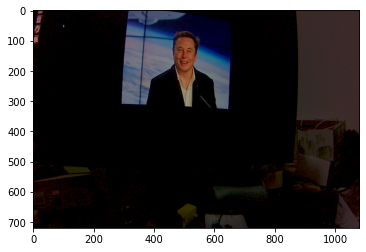

In [25]:
plt.imshow(imgS)
plt.show()
#print(name)

# 标记出席者
下面添加自动出席的代码。先写一个唯一输入值是用户名字的函数。先打开csv格式的出席文件，接着读取所有的行并循环执行。接着用逗号分隔，这样就能得到第一个元素是用户的名字。如果用户已经存在于文件中，就什么都不发生。如果用户不在文件中，用户和对应是时间戳就存放到文件中。可以使用data time包中的datetime类得到当前时间。


In [29]:
from datetime import datetime

In [30]:
def markAttendance(name):
    with open('Attendance2.csv','r+') as f:
        myDataList = f.readlines()
        nameList =[]
        for line in myDataList:
            entry = line.split(',')
            nameList.append(entry[0])
        if name not in  line:
            now = datetime.now()
            dt_string = now.strftime("%H:%M:%S")
            f.writelines(f'\n{name},{dt_string}')
#markAttendance('shi')

# 把陌生脸也标记上
如果发现陌生的脸，就用下面的方法：

In [31]:
if matches[matchIndex]:
    name = className[matchIndex].upper()
    #print(name)
    y1,x2,y2,x1 = faceLoc
    y1, x2, y2, x1 = y1*4,x2*4,y2*4,x1*4
    cv2.rectangle(imgS,(x1,y1),(x2,y2),(0,255,0),2)
    cv2.rectangle(imgS,(x1,y2-35),(x2,y2),(0,255,0),cv2.FILLED)
    cv2.putText(imgS,name,(x1+6,y2-6),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,255),2)
    markAttendance(name)

if faceDis[matchIndex]< 0.50:
    name = className[matchIndex].upper()
    markAttendance(name)
else: name = 'Unknown'
print(name)
y1,x2,y2,x1 = faceLoc
y1, x2, y2, x1 = y1*4,x2*4,y2*4,x1*4
cv2.rectangle(imgS,(x1,y1),(x2,y2),(0,255,0),2)
cv2.rectangle(imgS,(x1,y2-35),(x2,y2),(0,255,0),cv2.FILLED)
cv2.putText(imgS,name,(x1+6,y2-6),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,255),2)
print('finished')

ELON-MUSK
finished


做这些是检查和对应脸的相似的是否小于0.5。如果大于0.5，意味着这个人是陌生人，并把名字标记成unknowm，并且标记出席



# 结论：

opencv的人脸识别方法是面部识别中最简单和最快速的。